This dataset was created from the RAVDESS dataset (https://es.sonicurlprotection-fra.com/click?PV=2&MSGID=202209141411100289250&URLID=1&ESV=10.0.18.7423&IV=CDD893A9D96AB6D6469DFBAF03B52C7A&TT=1663164671774&ESN=SJ44mpH7HPEgdwadIHqGKE9aHAKB%2FGfCfiESv9Jnnj4%3D&KV=1536961729280&B64_ENCODED_URL=aHR0cHM6Ly96ZW5vZG8ub3JnL3JlY29yZC8xMTg4OTc2KSw&HK=3428F8A9C48043894424396B826370722E127A5AEC482B778236DC3B3D0A300B extracting basic statistics (mean, std, min, max, etc.) from the original audio data and after transforming it using: zero-crossing rate, Mel-Frequency Cepstral Coefficients, spectral centroid, and the stft chromagram. Features were extracted from the 2452 wav files.

Features:

-modality (audio-only)

-vocal_channel (speech, song)

-emotion (neutral, calm, happy, sad, angry, fearful, disgust, surprised)

-emotional_intensity (normal, strong). NOTE: There is no strong intensity for the 'neutral' emotion

-statement ("Kids are talking by the door", "Dogs are sitting by the door")

-repetition (1st repetition, 2nd repetition)

-actor (01 to 24)

-sex (M, F)

-channels (number of channels; 1 for mono, 2 for stereo audio)

-sample_width (number of bytes per sample; 1 means 8-bit, 2 means 16-bit)

-frame_rate (frequency of samples used (in Hertz))

-frame_width (Number of bytes for each âframeâ. One frame contains a sample for each channel.)

-length_ms (audio file length (in milliseconds))

-frame_count (the number of frames from the sample)

-intensity (loudness in dBFS (dB relative to the maximum possible loudness))

-zero_crossings_sum (sum of the zero-crossing rate)

-'mean', 'std', 'min', 'max', 'kur', 'skew' (statistics of the original audio signal)

-mfcc_ 'mean', 'std', 'min', 'max' (statistics of the Mel-Frequency Cepstral Coefficients)

-sc_ 'mean', 'std', 'min', 'max', 'kur', 'skew' (statistics of the spectral centroid)

-stft_ 'mean', 'std', 'min', 'max', 'kur', 'skew' (statistics of the stft chromagram)

In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates

In [3]:
df=pd.read_csv("ravdess_features.csv")

In [3]:
df

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
0,audio-only,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153
1,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F,1,2,...,0.000000,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157
2,audio-only,NaN,happy,strong,Dogs are sitting by the door,2nd,16.0,F,1,2,...,0.000000,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659
3,audio-only,NaN,surprised,normal,Kids are talking by the door,1st,14.0,F,1,2,...,0.000000,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014
4,audio-only,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F,1,2,...,0.000000,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,calm,strong,Kids are talking by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247
2448,audio-only,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M,1,2,...,0.000000,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633
2449,audio-only,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M,1,2,...,0.000000,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821
2450,audio-only,speech,surprised,normal,Kids are talking by the door,1st,NaN,M,1,2,...,0.001565,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966


In [4]:
df.dtypes

modality                object
vocal_channel           object
emotion                 object
emotional_intensity     object
statement               object
repetition              object
actor                  float64
sex                     object
channels                 int64
sample_width             int64
frame_rate               int64
frame_width              int64
length_ms                int64
frame_count            float64
intensity              float64
zero_crossings_sum       int64
mfcc_mean              float64
mfcc_std               float64
mfcc_min               float64
mfcc_max               float64
sc_mean                float64
sc_std                 float64
sc_min                 float64
sc_max                 float64
sc_kur                 float64
sc_skew                float64
stft_mean              float64
stft_std               float64
stft_min               float64
stft_max               float64
stft_kur               float64
stft_skew              float64
mean    

In [5]:
df[df.duplicated()]

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew


In [6]:
df=df.sort_values(by=["emotion"])
#print(df.to_string())

In [7]:
df.isna().sum()

modality                  0
vocal_channel           196
emotion                   0
emotional_intensity       0
statement                 0
repetition                0
actor                  1126
sex                       0
channels                  0
sample_width              0
frame_rate                0
frame_width               0
length_ms                 0
frame_count               0
intensity               816
zero_crossings_sum        0
mfcc_mean                 0
mfcc_std                  0
mfcc_min                  0
mfcc_max                  0
sc_mean                   0
sc_std                    0
sc_min                    0
sc_max                    0
sc_kur                    0
sc_skew                   0
stft_mean                 0
stft_std                  0
stft_min                  0
stft_max                  0
stft_kur                  0
stft_skew                 0
mean                      0
std                       0
min                       0
max                 

In [8]:
len(df[df["frame_count"]==-1])

35

In [9]:
len(df[df["sc_min"]==0])

1021

In [10]:
df.describe(include="all")

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_min,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew
count,2452,2256,2452,2452,2452,2452,1326.000000,2452,2452.000000,2452.0,...,2452.000000,2452.0,2452.000000,2452.000000,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
unique,1,2,8,2,2,2,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,audio-only,speech,angry,normal,Dogs are sitting by the door,1st,NaN,M,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2452,1335,376,1320,1226,1226,NaN,1248,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,12.582202,NaN,1.002447,2.0,...,0.002272,1.0,-1.247929,0.112889,1.393649e-08,0.020504,-0.164871,0.179839,11.203002,-0.048245
std,NaN,NaN,NaN,NaN,NaN,NaN,6.916240,NaN,0.049416,0.0,...,0.004830,0.0,0.211781,0.330759,4.267587e-05,0.021024,0.175443,0.195539,6.614859,0.454925
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,2.0,...,0.000000,1.0,-1.669603,-0.993957,-9.435575e-04,0.000652,-0.998810,0.004669,1.757794,-2.356526
25%,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,1.000000,2.0,...,0.000000,1.0,-1.390612,-0.094334,-1.394488e-06,0.006791,-0.202431,0.055489,6.519988,-0.336624
50%,NaN,NaN,NaN,NaN,NaN,NaN,13.000000,NaN,1.000000,2.0,...,0.000190,1.0,-1.292105,0.126065,-9.810701e-08,0.013880,-0.103775,0.109726,9.828686,0.004256
75%,NaN,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,1.000000,2.0,...,0.001999,1.0,-1.152519,0.335574,8.363511e-07,0.026154,-0.054352,0.224487,14.085435,0.262978


### Filling missing values

In [4]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df.drop(columns=["sample_width", "frame_rate", "stft_max"]).corr().style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,frame_width,length_ms,frame_count,intensity,zero_crossings_sum,mfcc_mean,mfcc_std,mfcc_min,mfcc_max,sc_mean,sc_std,sc_min,sc_max,sc_kur,sc_skew,stft_mean,stft_std,stft_min,stft_kur,stft_skew,mean,std,min,max,kur,skew
vocal_channel,1.000000,-0.117546,-0.007871,-0.001159,0.003293,-0.009668,-0.030868,-0.025381,-0.025381,0.781790,0.596990,0.314275,0.147890,0.044760,-0.289413,0.198156,-0.291907,-0.530974,-0.148120,-0.046524,-0.131935,0.253271,0.582225,-0.496571,0.412953,-0.202317,-0.124253,0.527645,0.020012,0.136706,-0.027131,0.033182,-0.526163,0.031374
emotion,-0.117546,1.000000,-0.025232,-0.000000,-0.000000,0.035022,0.002526,-0.001487,-0.001487,0.109358,0.095047,-0.500615,-0.143288,-0.353201,0.483877,-0.485345,0.170022,0.086846,0.256006,-0.103077,0.097635,-0.225066,-0.148358,0.065167,-0.034698,0.087962,0.012074,-0.081790,-0.027014,-0.448534,0.454366,-0.458947,0.007355,-0.190015
emotional_intensity,-0.007871,-0.025232,1.000000,0.000000,0.000000,-0.018823,0.000256,-0.045865,-0.045865,0.114027,0.092486,0.372473,0.254869,0.305904,-0.416725,0.403562,-0.213957,-0.118081,-0.256610,0.076052,-0.090582,0.233992,0.197154,-0.081052,0.031236,-0.085916,0.004877,0.107097,-0.018088,0.400001,-0.416768,0.417563,0.038873,0.123895
statement,-0.001159,-0.000000,0.000000,1.000000,-0.000000,0.005819,-0.000000,0.000000,0.000000,0.029536,0.057054,-0.061896,-0.162901,0.019976,0.022503,-0.010737,-0.002525,-0.083286,-0.075070,-0.012920,0.003062,0.075559,0.076676,-0.001038,-0.057050,-0.000847,0.079564,0.011607,-0.000582,-0.025725,0.005634,0.001904,0.168459,0.032291
repetition,0.003293,-0.000000,0.000000,-0.000000,1.000000,-0.002870,0.000000,0.016509,0.016509,0.015751,0.026718,0.023421,0.016961,0.011494,-0.018511,0.013579,-0.002847,-0.010039,-0.013379,0.008414,-0.010509,0.005785,0.009429,-0.012592,0.007671,0.005653,-0.004754,0.014438,-0.001771,0.018927,-0.009472,0.008832,-0.028316,-0.005024
actor,-0.009668,0.035022,-0.018823,0.005819,-0.002870,1.000000,0.069798,-0.021199,-0.021199,0.043038,0.039325,0.061923,-0.059671,-0.065308,-0.012426,0.045965,-0.028036,0.060292,0.119453,-0.046160,0.083882,-0.132716,-0.066964,-0.039657,0.082993,0.027860,-0.064000,0.007862,0.020220,0.032818,-0.009776,0.015928,-0.023939,0.065606
sex,-0.030868,0.002526,0.000256,-0.000000,0.000000,0.069798,1.000000,0.000889,0.000889,0.071584,0.056466,0.084475,0.389077,-0.539941,-0.108791,0.126288,-0.545416,0.042652,0.100327,-0.301492,0.203118,-0.019193,-0.007658,-0.574827,0.578974,-0.422499,-0.129566,0.462716,-0.011271,0.083554,-0.052830,0.053374,-0.118022,0.122251
channels,-0.025381,-0.001487,-0.045865,0.000000,0.016509,-0.021199,0.000889,1.000000,1.000000,-0.011438,-0.005109,-0.058387,-0.039588,-0.058672,0.055940,-0.045564,0.025047,0.056692,0.062773,-0.038106,0.017277,-0.041518,-0.048661,0.025579,-0.015658,-0.007655,0.009364,-0.030689,0.000447,-0.034657,0.034420,-0.032340,0.024764,0.022957
frame_width,-0.025381,-0.001487,-0.045865,0.000000,0.016509,-0.021199,0.000889,1.000000,1.000000,-0.011438,-0.005109,-0.058387,-0.039588,-0.058672,0.055940,-0.045564,0.025047,0.056692,0.062773,-0.038106,0.017277,-0.041518,-0.048661,0.025579,-0.015658,-0.007655,0.009364,-0.030689,0.000447,-0.034657,0.034420,-0.032340,0.024764,0.022957
length_ms,0.781790,0.109358,0.114027,0.029536,0.015751,0.043038,0.071584,-0.011438,-0.011438,1.000000,0.762874,0.293782,0.329517,0.011321,-0.302735,0.205996,-0.347253,-0.546234,-0.182306,-0.077001,-0.118781,0.292127,0.621148,-0.561395,0.409380,-0.245511,-0.072309,0.602057,0.004213,0.167134,-0.070644,0.072309,-0.460723,0.064473


In [5]:
df["vocal_channel_fill1"]=df["vocal_channel"]
df["vocal_channel_fill1"]=df["vocal_channel_fill1"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mode()[0]))
df["vocal_channel"]=df["vocal_channel"].replace([0,1],["speech", "song"])
df["vocal_channel_fill1"]=df["vocal_channel_fill1"].replace([0,1],["speech", "song"])

In [13]:
df["vocal_channel"].count()

2256

In [14]:
df["vocal_channel_fill1"].count()

2452

In [15]:
df[(df["vocal_channel_fill1"]!="speech") & (df["vocal_channel_fill1"]!="song")]

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew,vocal_channel_fill1


/tmp/ipykernel_5181/3208566856.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


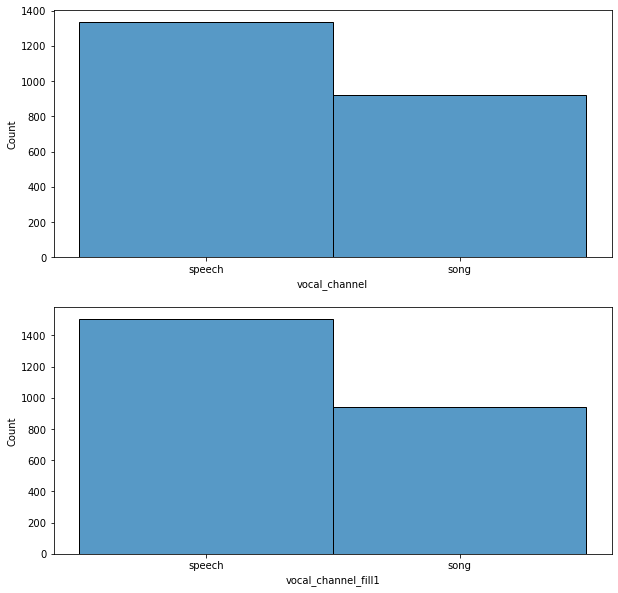

In [16]:
fig, axes=plt.subplots(2, figsize=(10,10))
sns.histplot(data=df, x="vocal_channel", ax=axes[0])
sns.histplot(data=df, x="vocal_channel_fill1", ax=axes[1])
fig.show()

In [17]:
df["intensity_fill1"]=df["intensity"]
df["intensity_fill1"]=df["intensity_fill1"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [18]:
df["intensity"].count()

1636

In [19]:
df["intensity_fill1"].count()

2452

/tmp/ipykernel_5181/1396965744.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


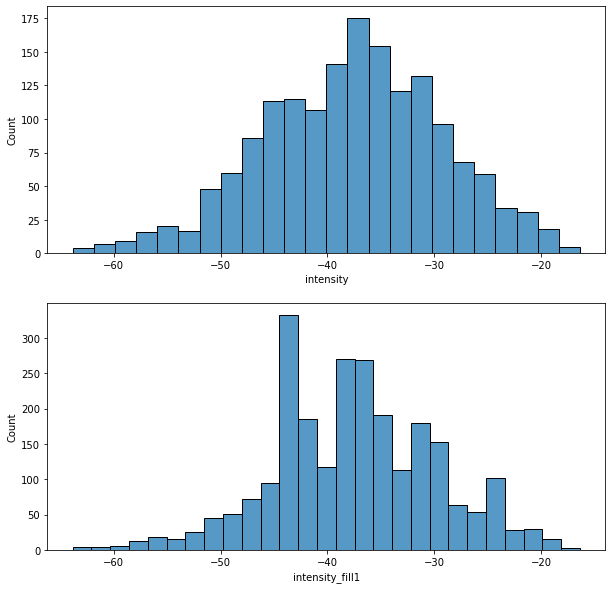

In [20]:
fig, axes=plt.subplots(2, figsize=(10,10))
sns.histplot(data=df, x="intensity", ax=axes[0])
sns.histplot(data=df, x="intensity_fill1", ax=axes[1])
fig.show()

In [21]:
df["frame_count_fill"]=df["frame_count"]
df["frame_count_fill"]=df["frame_count_fill"].groupby([df["emotion"], df["emotional_intensity"]]).apply(lambda x: x.fillna(x.mean()))

In [22]:
#variabili correlate più interessanti
df.corr().loc[["intensity_fill1", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"], ["intensity_fill1", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"]].style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)

,intensity_fill1,sex,emotion,emotional_intensity,mfcc_std,mfcc_min,sc_mean,sc_std,sc_kur,sc_skew,stft_mean,stft_std,stft_skew,std,min,max
intensity_fill1,1.000000,0.068257,-0.549530,0.405435,-0.903944,0.901106,-0.272522,-0.414052,0.346526,0.357941,-0.275297,0.195825,0.306799,0.806389,-0.783290,0.786313
sex,0.068257,1.000000,0.002526,0.000256,-0.108791,0.126288,0.042652,0.100327,-0.019193,-0.007658,-0.574827,0.578974,0.462716,0.083554,-0.052830,0.053374
emotion,-0.549530,0.002526,1.000000,-0.025232,0.483877,-0.485345,0.086846,0.256006,-0.225066,-0.148358,0.065167,-0.034698,-0.081790,-0.448534,0.454366,-0.458947
emotional_intensity,0.405435,0.000256,-0.025232,1.000000,-0.416725,0.403562,-0.118081,-0.256610,0.233992,0.197154,-0.081052,0.031236,0.107097,0.400001,-0.416768,0.417563
mfcc_std,-0.903944,-0.108791,0.483877,-0.416725,1.000000,-0.976098,0.369792,0.524719,-0.453798,-0.473588,0.365598,-0.229781,-0.411195,-0.844623,0.816134,-0.810939
mfcc_min,0.901106,0.126288,-0.485345,0.403562,-0.976098,1.000000,-0.285340,-0.453582,0.368018,0.360212,-0.306645,0.224710,0.330945,0.842259,-0.828536,0.822831
sc_mean,-0.272522,0.042652,0.086846,-0.118081,0.369792,-0.285340,1.000000,0.529673,-0.626227,-0.823353,0.562423,-0.322951,-0.637220,-0.217910,0.174301,-0.169879
sc_std,-0.414052,0.100327,0.256006,-0.256610,0.524719,-0.453582,0.529673,1.000000,-0.619887,-0.401971,0.085997,0.199808,-0.225841,-0.428090,0.423219,-0.406799
sc_kur,0.346526,-0.019193,-0.225066,0.233992,-0.453798,0.368018,-0.626227,-0.619887,1.000000,0.770684,-0.330428,0.059976,0.426984,0.373452,-0.346908,0.348443
sc_skew,0.357941,-0.007658,-0.148358,0.197154,-0.473588,0.360212,-0.823353,-0.401971,0.770684,1.000000,-0.562856,0.368663,0.635692,0.329005,-0.264592,0.266187


# Distribuzioni e Outliers

/tmp/ipykernel_5181/3170514600.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5181/3170514600.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


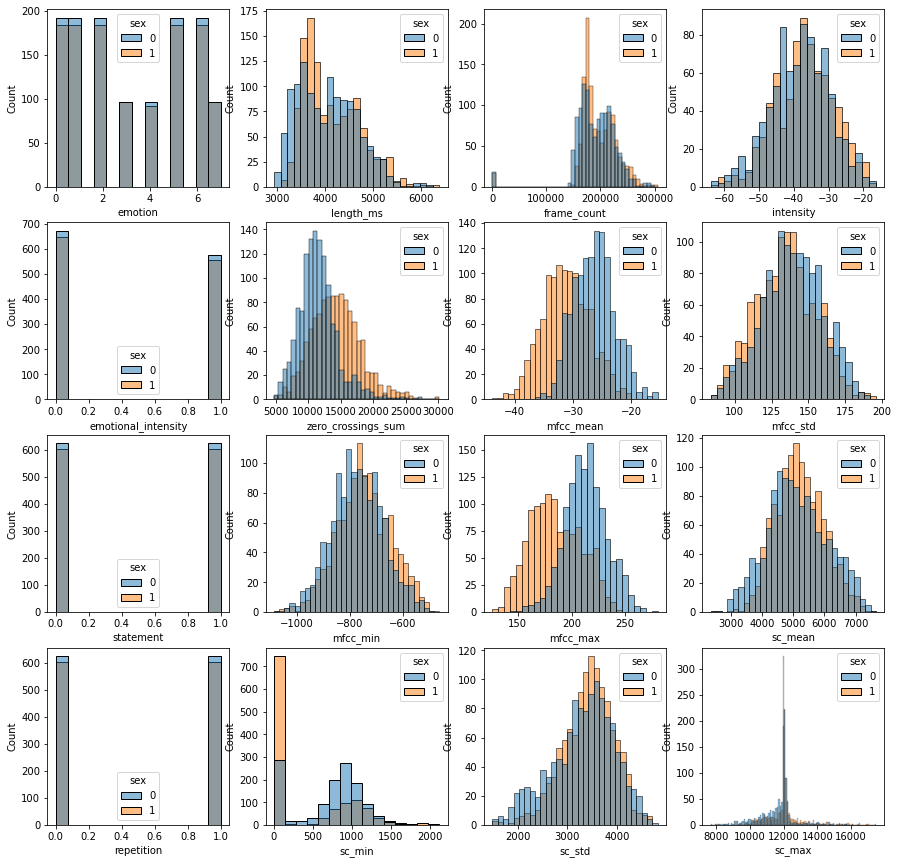

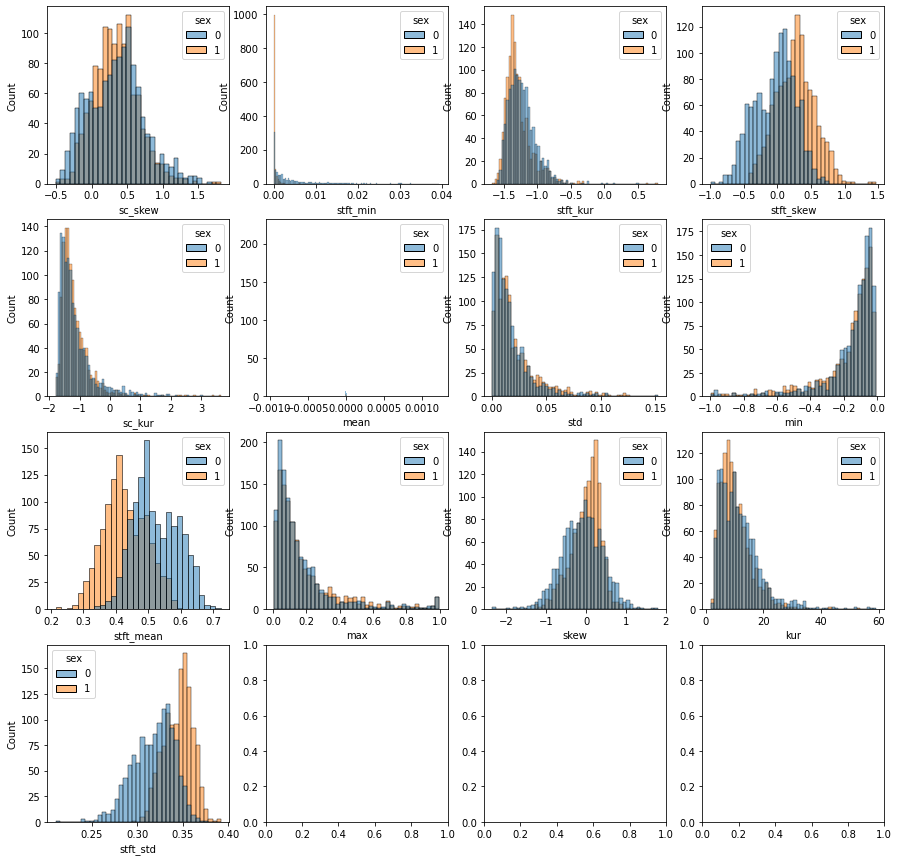

In [23]:
#istogrammi divisi per genere
fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.histplot(data=df, x="emotion", hue="sex", ax=axs[0][0])
sns.histplot(data=df, x="emotional_intensity", hue="sex", ax=axs[1][0])
sns.histplot(data=df, x="statement", hue="sex", ax=axs[2][0])
sns.histplot(data=df, x="repetition", hue="sex", ax=axs[3][0])
sns.histplot(data=df, x="length_ms", hue="sex", ax=axs[0][1])
sns.histplot(data=df, x="frame_count", hue="sex", ax=axs[0][2])
sns.histplot(data=df, x="intensity", hue="sex", ax=axs[0][3])
sns.histplot(data=df, x="zero_crossings_sum", hue="sex", ax=axs[1][1])
sns.histplot(data=df, x="mfcc_mean", hue="sex", ax=axs[1][2])
sns.histplot(data=df, x="mfcc_std", hue="sex", ax=axs[1][3])
sns.histplot(data=df, x="mfcc_min", hue="sex", ax=axs[2][1])
sns.histplot(data=df, x="mfcc_max", hue="sex", ax=axs[2][2])
sns.histplot(data=df, x="sc_mean", hue="sex", ax=axs[2][3])
sns.histplot(data=df, x="sc_min", hue="sex", ax=axs[3][1])
sns.histplot(data=df, x="sc_std", hue="sex", ax=axs[3][2])
sns.histplot(data=df, x="sc_max", hue="sex", ax=axs[3][3])
fig.show()

fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.histplot(data=df, x="sc_skew", hue="sex", ax=axs[0][0])
sns.histplot(data=df, x="sc_kur", hue="sex", ax=axs[1][0])
sns.histplot(data=df, x="stft_mean", hue="sex", ax=axs[2][0])
sns.histplot(data=df, x="stft_std", hue="sex", ax=axs[3][0])
sns.histplot(data=df, x="stft_min", hue="sex", ax=axs[0][1])
sns.histplot(data=df, x="stft_kur", hue="sex", ax=axs[0][2])
sns.histplot(data=df, x="stft_skew", hue="sex", ax=axs[0][3])
sns.histplot(data=df, x="mean", hue="sex", ax=axs[1][1])
sns.histplot(data=df, x="std", hue="sex", ax=axs[1][2])
sns.histplot(data=df, x="min", hue="sex", ax=axs[1][3])
sns.histplot(data=df, x="max", hue="sex", ax=axs[2][1])
sns.histplot(data=df, x="skew", hue="sex", ax=axs[2][2])
sns.histplot(data=df, x="kur", hue="sex", ax=axs[2][3])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][1])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][2])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][3])
fig.show()

/tmp/ipykernel_5181/324148993.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_5181/324148993.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


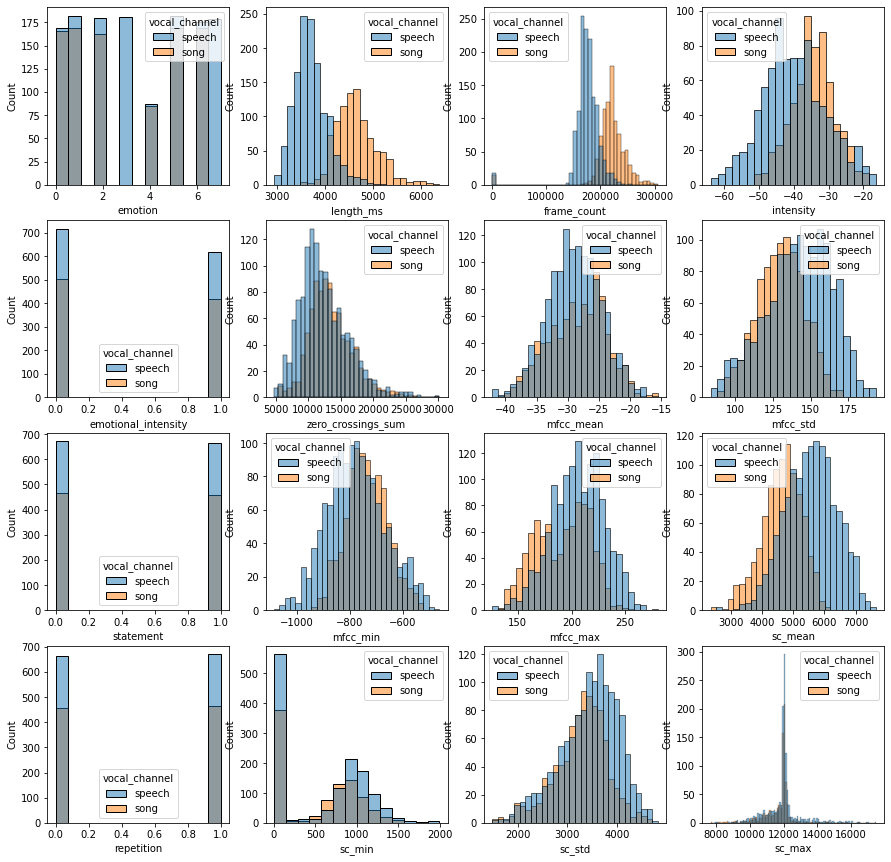

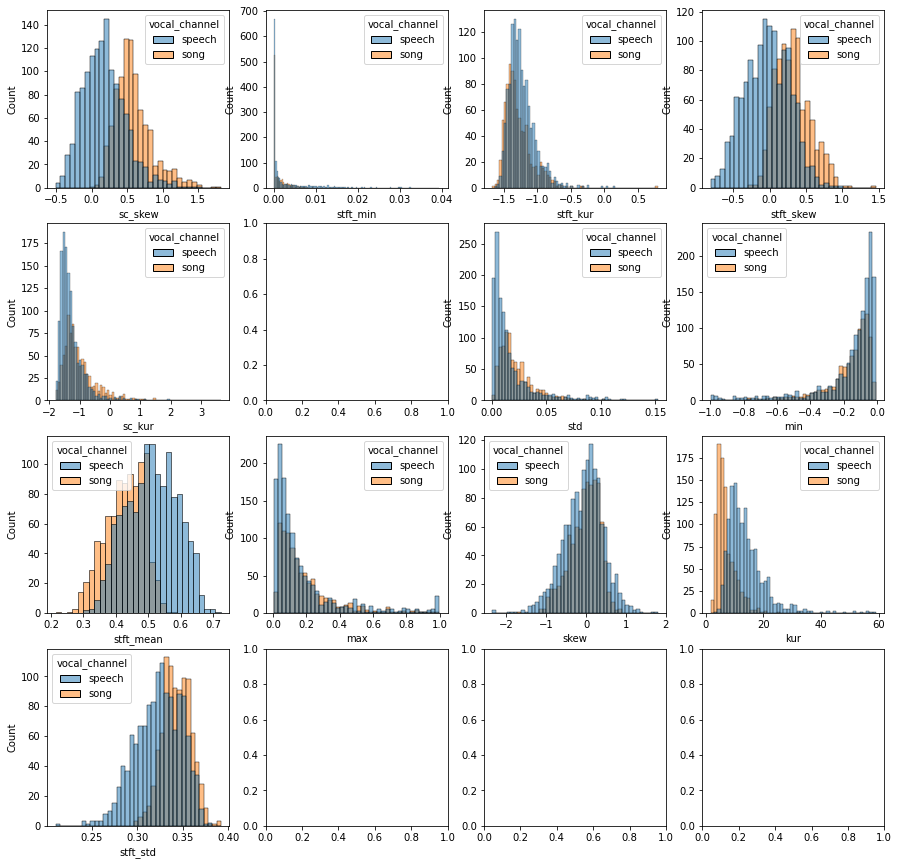

In [24]:
#istogrammi divisi per vocal channel
fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.histplot(data=df, x="emotion", hue="vocal_channel", ax=axs[0][0])
sns.histplot(data=df, x="emotional_intensity", hue="vocal_channel", ax=axs[1][0])
sns.histplot(data=df, x="statement", hue="vocal_channel", ax=axs[2][0])
sns.histplot(data=df, x="repetition", hue="vocal_channel", ax=axs[3][0])
sns.histplot(data=df, x="length_ms", hue="vocal_channel", ax=axs[0][1])
sns.histplot(data=df, x="frame_count", hue="vocal_channel", ax=axs[0][2])
sns.histplot(data=df, x="intensity", hue="vocal_channel", ax=axs[0][3])
sns.histplot(data=df, x="zero_crossings_sum", hue="vocal_channel", ax=axs[1][1])
sns.histplot(data=df, x="mfcc_mean", hue="vocal_channel", ax=axs[1][2])
sns.histplot(data=df, x="mfcc_std", hue="vocal_channel", ax=axs[1][3])
sns.histplot(data=df, x="mfcc_min", hue="vocal_channel", ax=axs[2][1])
sns.histplot(data=df, x="mfcc_max", hue="vocal_channel", ax=axs[2][2])
sns.histplot(data=df, x="sc_mean", hue="vocal_channel", ax=axs[2][3])
sns.histplot(data=df, x="sc_min", hue="vocal_channel", ax=axs[3][1])
sns.histplot(data=df, x="sc_std", hue="vocal_channel", ax=axs[3][2])
sns.histplot(data=df, x="sc_max", hue="vocal_channel", ax=axs[3][3])
fig.show()

fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.histplot(data=df, x="sc_skew", hue="vocal_channel", ax=axs[0][0])
sns.histplot(data=df, x="sc_kur", hue="vocal_channel", ax=axs[1][0])
sns.histplot(data=df, x="stft_mean", hue="vocal_channel", ax=axs[2][0])
sns.histplot(data=df, x="stft_std", hue="vocal_channel", ax=axs[3][0])
sns.histplot(data=df, x="stft_min", hue="vocal_channel", ax=axs[0][1])
sns.histplot(data=df, x="stft_kur", hue="vocal_channel", ax=axs[0][2])
sns.histplot(data=df, x="stft_skew", hue="vocal_channel", ax=axs[0][3])
#sns.histplot(data=df, x="mean", hue="sex", ax=axs[1][1])
sns.histplot(data=df, x="std", hue="vocal_channel", ax=axs[1][2])
sns.histplot(data=df, x="min", hue="vocal_channel", ax=axs[1][3])
sns.histplot(data=df, x="max", hue="vocal_channel", ax=axs[2][1])
sns.histplot(data=df, x="skew", hue="vocal_channel", ax=axs[2][2])
sns.histplot(data=df, x="kur", hue="vocal_channel", ax=axs[2][3])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][1])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][2])
#sns.histplot(data=df, x="", hue="sex", ax=axs[3][3])
fig.show()

In [ ]:
#boxplot divisi per emozione
fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.boxplot(data=df, x="length_ms", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="frame_count", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="intensity", y="emotion", ax=axs[0][2])
sns.boxplot(data=df, x="zero_crossings_sum", y="emotion", ax=axs[0][3])
sns.boxplot(data=df, x="mfcc_mean", y="emotion", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_std", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="mfcc_min", y="emotion", ax=axs[1][2])
sns.boxplot(data=df, x="mfcc_max", y="emotion", ax=axs[1][3])
sns.boxplot(data=df, x="sc_mean", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="sc_std", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="sc_max", y="emotion", ax=axs[2][2])
sns.boxplot(data=df, x="sc_min", y="emotion", ax=axs[2][3])
sns.boxplot(data=df, x="sc_kur", y="emotion", ax=axs[3][0])
sns.boxplot(data=df, x="sc_skew", y="emotion", ax=axs[3][1])
sns.boxplot(data=df, x="stft_mean", y="emotion", ax=axs[3][2])
sns.boxplot(data=df, x="stft_std", y="emotion", ax=axs[3][3])
fig.show()

fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.boxplot(data=df, x="stft_min", y="emotion", ax=axs[0][0])
sns.boxplot(data=df, x="max", y="emotion", ax=axs[0][1])
sns.boxplot(data=df, x="stft_kur", y="emotion", ax=axs[0][2])
sns.boxplot(data=df, x="stft_skew", y="emotion", ax=axs[1][0])
#sns.boxplot(data=df, x="mean", y="emotion", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="emotion", ax=axs[1][2])
sns.boxplot(data=df, x="min", y="emotion", ax=axs[2][0])
sns.boxplot(data=df, x="kur", y="emotion", ax=axs[2][1])
sns.boxplot(data=df, x="skew", y="emotion", ax=axs[2][2])
fig.show()

In [ ]:
#boxplot divisi per genere
fig, axs=plt.subplots(4,4,figsize=(15,15))
sns.boxplot(data=df, x="length_ms", y="sex", ax=axs[0][0])
sns.boxplot(data=df, x="frame_count", y="sex", ax=axs[0][1])
sns.boxplot(data=df, x="intensity", y="sex", ax=axs[0][2])
sns.boxplot(data=df, x="zero_crossings_sum", y="sex", ax=axs[0][3])
sns.boxplot(data=df, x="mfcc_mean", y="sex", ax=axs[1][0])
sns.boxplot(data=df, x="mfcc_std", y="sex", ax=axs[1][1])
sns.boxplot(data=df, x="mfcc_min", y="sex", ax=axs[1][2])
sns.boxplot(data=df, x="mfcc_max", y="sex", ax=axs[1][3])
sns.boxplot(data=df, x="sc_mean", y="sex", ax=axs[2][0])
sns.boxplot(data=df, x="sc_std", y="sex", ax=axs[2][1])
sns.boxplot(data=df, x="sc_max", y="sex", ax=axs[2][2])
sns.boxplot(data=df, x="sc_min", y="sex", ax=axs[2][3])
sns.boxplot(data=df, x="sc_kur", y="sex", ax=axs[3][0])
sns.boxplot(data=df, x="sc_skew", y="sex", ax=axs[3][1])
sns.boxplot(data=df, x="stft_mean", y="sex", ax=axs[3][2])
sns.boxplot(data=df, x="stft_std", y="sex", ax=axs[3][3])
fig.show()

fig, axs=plt.subplots(3,3,figsize=(15,15))
sns.boxplot(data=df, x="stft_min", y="sex", ax=axs[0][0])
sns.boxplot(data=df, x="max", y="sex", ax=axs[0][1])
sns.boxplot(data=df, x="stft_kur", y="sex", ax=axs[0][2])
sns.boxplot(data=df, x="stft_skew", y="sex", ax=axs[1][0])
sns.boxplot(data=df, x="mean", y="sex", ax=axs[1][1])
sns.boxplot(data=df, x="std", y="sex", ax=axs[1][2])
sns.boxplot(data=df, x="min", y="sex", ax=axs[2][0])
sns.boxplot(data=df, x="kur", y="sex", ax=axs[2][1])
sns.boxplot(data=df, x="skew", y="sex", ax=axs[2][2])
fig.show()

### Normality test

In [6]:
df

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,channels,sample_width,...,stft_max,stft_kur,stft_skew,mean,std,min,max,kur,skew,vocal_channel_fill1
0,audio-only,speech,0,0,0,1,2.0,1,1,2,...,1.0,-1.215025,0.403514,3.844916e-07,0.014482,-0.128632,0.138947,9.406061,0.273153,speech
1,audio-only,speech,1,0,0,0,16.0,1,1,2,...,1.0,-1.384174,0.290905,-7.149491e-08,0.020417,-0.305725,0.263062,19.564187,0.292157,speech
2,audio-only,NaN,2,1,0,1,16.0,1,1,2,...,1.0,-1.242947,0.470350,2.429985e-06,0.024317,-0.137482,0.166351,4.881241,0.302659,speech
3,audio-only,NaN,3,0,1,0,14.0,1,1,2,...,1.0,-1.445318,0.274756,2.373929e-07,0.003561,-0.027374,0.024078,13.040259,-0.081014,speech
4,audio-only,song,2,1,0,1,2.0,1,1,2,...,1.0,-1.366742,0.318926,8.454691e-07,0.027522,-0.192169,0.242676,7.485109,0.414872,song
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,audio-only,speech,5,1,1,0,23.0,0,1,2,...,1.0,-1.075888,-0.310088,9.367040e-07,0.005260,-0.039856,0.052399,9.551363,0.759247,speech
2448,audio-only,speech,5,0,0,0,23.0,0,1,2,...,1.0,-1.026071,-0.408018,4.614221e-07,0.006836,-0.064178,0.084045,22.517991,1.073633,speech
2449,audio-only,song,6,1,0,1,23.0,0,1,2,...,1.0,-1.473789,0.130310,-8.219263e-06,0.015384,-0.093079,0.097260,4.964319,-0.005821,song
2450,audio-only,speech,3,0,1,0,NaN,0,1,2,...,1.0,-1.277117,-0.242668,-4.400898e-06,0.005182,-0.057556,0.052002,13.855588,-0.110966,speech


In [7]:
df["emotion"]=df["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df["emotional_intensity"]=df["emotional_intensity"].replace(["normal", "strong"],[0,1])
df["vocal_channel"]=df["vocal_channel"].replace(["speech", "song"],[0,1])
df["repetition"]=df["repetition"].replace(["1st", "2nd"],[0,1])
df["sex"]=df["sex"].replace(["M", "F"],[0,1])
df["statement"]=df["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
for i in df.drop(columns=["modality"]):
    stat, p = shapiro(df[i])
    if (p>0.05):
        print(i, stat, p, "  Shapiro: probably gaussian")
    else:
        print(i, stat, p, "  Shapiro: probably not gaussian")


vocal_channel nan 1.0   Shapiro: probably gaussian
emotion 0.906316876411438 2.120309056000314e-36   Shapiro: probably not gaussian
emotional_intensity 0.6344887614250183 0.0   Shapiro: probably not gaussian
statement 0.6366180777549744 0.0   Shapiro: probably not gaussian
repetition 0.6366180777549744 0.0   Shapiro: probably not gaussian
actor nan 1.0   Shapiro: probably gaussian
sex 0.6364985704421997 0.0   Shapiro: probably not gaussian
channels 0.023883342742919922 0.0   Shapiro: probably not gaussian
sample_width 1.0 1.0   Shapiro: probably gaussian
frame_rate 1.0 1.0   Shapiro: probably gaussian
frame_width 0.023883342742919922 0.0   Shapiro: probably not gaussian
length_ms 0.9638106822967529 2.5573002919072092e-24   Shapiro: probably not gaussian
frame_count 0.8501862287521362 2.620428128287408e-43   Shapiro: probably not gaussian
intensity nan 1.0   Shapiro: probably gaussian
zero_crossings_sum 0.9704989194869995 4.670527603532115e-22   Shapiro: probably not gaussian
mfcc_mean 

/home/alessandro/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


ValueError: could not convert string to float: 'song'

### Missing values vocal_channel

In [ ]:
#dfnull=df[df["emotion"]=="happy"]
len(df[df["vocal_channel"].isnull()])

In [ ]:
fig, axs=plt.subplots(5,2,figsize=(40,30))
sns.histplot(data=df, x="length_ms", hue="vocal_channel", ax=axs[0][0], bins=100)
sns.histplot(data=df, x="intensity", hue="vocal_channel", ax=axs[0][1], bins=100)
sns.histplot(data=df, x="frame_count", hue="vocal_channel", ax=axs[1][0], bins=100)
sns.histplot(data=df, x="mfcc_std", hue="vocal_channel", ax=axs[1][1], bins=100)
sns.histplot(data=df, x="sc_mean", hue="vocal_channel", ax=axs[2][0], bins=100)
sns.histplot(data=df, x="sc_skew", hue="vocal_channel", ax=axs[2][1], bins=100)
sns.histplot(data=df, x="stft_skew", hue="vocal_channel", ax=axs[3][0], bins=100)
sns.histplot(data=df, x="stft_mean", hue="vocal_channel", ax=axs[3][1], bins=100)
sns.histplot(data=df, x="stft_std", hue="vocal_channel", ax=axs[4][0], bins=100)
sns.histplot(data=df, x="kur", hue="vocal_channel", ax=axs[4][1], bins=100)
fig.show()

In [ ]:
dfcopy2=df.copy()
dfcopy1=df

In [ ]:
#rimpiazzo dei Nan in vocal channel (metodo sbagliato)
df["vocal_channel_fill2"] = np.where(
    (df["vocal_channel"].isnull()) & (df["frame_count"]>1) &
    ((df["frame_count"]<190000) | (df["length_ms"]<4000) | (df["intensity"]<-45) | (df["mfcc_std"]>155) | (df["sc_mean"]>5500) | (df["sc_skew"]<0.25) | (df["sc_mean"]>5700) | (df["stft_skew"]<-0.1) | (df["stft_mean"]>0.52) | (df["stft_std"]<0.315) | (df["kur"]>13)), "speech", df["vocal_channel"])
df["vocal_channel_fill2"] = np.where(
    (df["vocal_channel"].isnull()) &
    ((df["frame_count"]>210000) | (df["length_ms"]>4250) | (df["sc_mean"]<4000) | (df["stft_skew"]>0.48) | (df["stft_mean"]<0.35) | (df["kur"]<6)), "song", df["vocal_channel"])

In [ ]:
len(df[df["vocal_channel"].isnull()])

In [ ]:
df["vocal_channel_fill2"].count()

In [ ]:
df

In [ ]:
dfspeech=df[df["vocal_channel"]==1.0]
dfsong=df[df["vocal_channel"]==0.0]
dfspeech

In [ ]:
fig, axs=plt.subplots(2,2,figsize=(15,15))
sns.histplot(data=dfcopy1, x="length_ms", hue="vocal_channel", ax=axs[0][0])
sns.histplot(data=dfcopy1, x="frame_count", hue="vocal_channel", ax=axs[1][0])
sns.histplot(data=df, x="length_ms", hue="vocal_channel", ax=axs[0][1])
sns.histplot(data=df, x="frame_count", hue="vocal_channel", ax=axs[1][1])
fig.show()

# Emozioni

Analisi separata per intensità dell'emozione

In [ ]:
df.head()

In [ ]:
dfnormal=df[df["emotional_intensity"]==1]
dfstrong=df[df["emotional_intensity"]==0]

In [ ]:
#min dfstrong
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfstrong, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfstrong, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfstrong, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfstrong, x="stft_min", hue="emotion", ax=axs[1][1])

In [ ]:
#min dfnormal
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfnormal, x="min", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfnormal, x="mfcc_min", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfnormal, x="sc_min", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfnormal, x="stft_min", hue="emotion", ax=axs[1][1])

In [ ]:
#mean dfnormal
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfnormal, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfnormal, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfnormal, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfnormal, x="stft_mean", hue="emotion", ax=axs[1][1])

In [ ]:
#mean dfstrong
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfstrong, x="mean", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfstrong, x="mfcc_mean", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfstrong, x="sc_mean", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfstrong, x="stft_mean", hue="emotion", ax=axs[1][1])

In [ ]:
#std dfnormal
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfnormal, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfnormal, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfnormal, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfnormal, x="stft_std", hue="emotion", ax=axs[1][1])

In [ ]:
#std dfstrong
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfstrong, x="std", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfstrong, x="mfcc_std", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfstrong, x="sc_std", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfstrong, x="stft_std", hue="emotion", ax=axs[1][1])

In [ ]:
#skew and length dfnormal
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfnormal, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfnormal, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfnormal, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfnormal, x="stft_skew", hue="emotion", ax=axs[1][1])

In [ ]:
#skew and length dfstrong
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfstrong, x="skew", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfstrong, x="length_ms", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfstrong, x="sc_skew", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfstrong, x="stft_skew", hue="emotion", ax=axs[1][1])

In [ ]:
#zero-crossing-sum and kurtosis dfnormal
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfnormal, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfnormal, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfnormal, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfnormal, x="stft_kur", hue="emotion", ax=axs[1][1])

In [ ]:
#zero-crossing-sum and kurtosis dfstrong
fig, axs = plt.subplots(2,2,figsize=(15,15))
sns.kdeplot(data=dfstrong, x="kur", hue="emotion", ax=axs[0][0])
sns.kdeplot(data=dfstrong, x="zero_crossings_sum", hue="emotion", ax=axs[0][1])
sns.kdeplot(data=dfstrong, x="sc_kur", hue="emotion", ax=axs[1][0])
sns.kdeplot(data=dfstrong, x="stft_kur", hue="emotion", ax=axs[1][1])

In [ ]:
sns.kdeplot(data=dfstrong, x="frame_count", hue="emotion")

### Analisi bivariabile (boh)

In [ ]:
sns.scatterplot(data=dfstrong, x="std", y="intensity", hue="emotion")

In [ ]:
sns.scatterplot(data=dfstrong, x="kur", y="stft_mean", hue="emotion")

In [ ]:
sns.boxplot(data=df, x="mfcc_mean", y="emotion")

In [ ]:
sns.boxplot(data=df, x="mfcc_std", y="emotion")

In [ ]:
sns.boxplot(data=df, x="mfcc_min", y="emotion")

In [ ]:
sns.boxplot(data=df, x="mfcc_max", y="emotion")

In [ ]:
sns.boxplot(data=df, x="std", y="emotion")

In [ ]:
sns.boxplot(data=df, x="min", y="emotion")

In [ ]:
sns.boxplot(data=df, x="max", y="emotion")

In [ ]:
sns.boxplot(data=df, x="length_ms", y="emotion")

In [ ]:
sns.boxplot(data=df, x="intensity", y="emotion")

In [ ]:
sns.boxplot(data=df, x="frame_count", y="emotion")

In [ ]:
df.corr().loc[["intensity_fill", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"], ["intensity", "sex", "emotion", "emotional_intensity", "mfcc_std", "mfcc_min", "sc_mean", "sc_std", "sc_kur", "sc_skew", "stft_mean", "stft_std", "stft_skew", "std", "min", "max"]].style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1)